# Multilayer perceptron

Pytorch framework documentation [here](https://pytorch.org/)

Num |      categorica \
0   = [1,0,0,0,0,0,0,0,0,0] \
5   = [0,0,0,0,0,1,0,0,0,0] \
3   = [0,0,0,1,0,0,0,0,0,0] \
7   = [0,0,0,0,0,0,0,1,0,0] \

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import time
from tqdm import tqdm
from keras.utils import to_categorical

import torch
import torch.nn as nn

## Load data - [MNIST](http://yann.lecun.com/exdb/mnist/)

In [2]:
# Load MNIST data
train_data = pd.read_csv( "/content/sample_data/mnist_train_small.csv" , header=None)
test_data  = pd.read_csv( "/content/sample_data/mnist_test.csv", header=None)

train_data.head(5)

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
X_train = np.array(train_data.iloc[:, 1:]).reshape([-1, 28, 28])
y_train = np.array(train_data.iloc[:, 0])

X_test = np.array(test_data.iloc[:, 1:]).reshape([-1, 28, 28])
y_test = np.array(test_data.iloc[:, 0])

print (X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(20000, 28, 28) (20000,) (10000, 28, 28) (10000,)


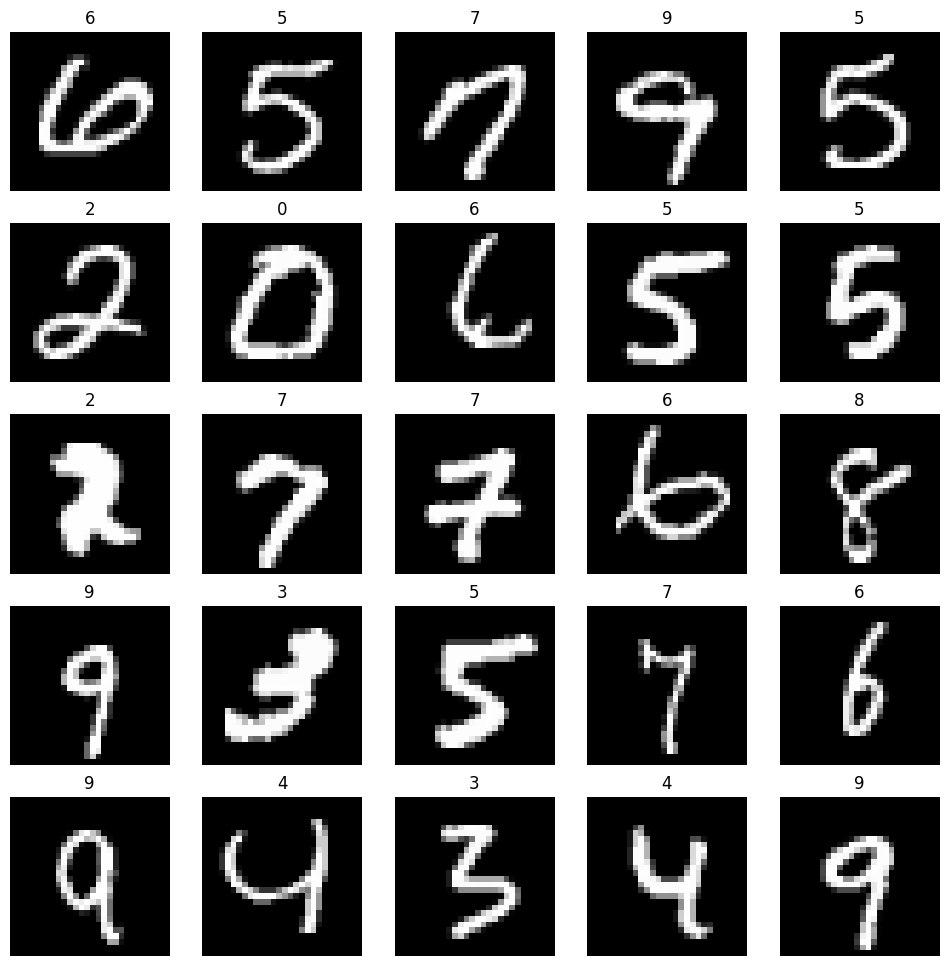

In [4]:
# Visualize grid of samples
grid_size = (5,5)

_, axes = plt.subplots ( grid_size[0] , grid_size[1] , figsize=(12,12))
axes = axes.ravel()

for i, ax in enumerate(axes):
  ax.imshow( X_train[i] , cmap='gray')
  ax.set_axis_off()
  ax.set_title(y_train[i])

In [5]:
print("X_train Min-Max: [{0:.3f} - {1:.3f}]".format(X_train.min(), X_train.max()))

X_train Min-Max: [0.000 - 255.000]


In [6]:
# Reshape the data - MLPs do not understand such '2D' stuff
# Reshape to 1D is similat to "flatten" an image

# Configuration options
feature_vector_length = 784
num_classes = 10

X_train = X_train.reshape([-1, feature_vector_length])
X_test  = X_test.reshape ([-1, feature_vector_length])

# Convert into 0 - 1 values
X_train = X_train / 255.0
X_test = X_test / 255.0

In [7]:
# Convert target classes to categorical ones - one hot encoding
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [8]:
print (X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(20000, 784) (10000, 784) (20000, 10) (10000, 10)


In [9]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


## Create a graph model

In [10]:
# Model params for training
epochs = 100
batch_size = 200 # We dont train the whole dataset at the time
losses = []

In [11]:
model = nn.Sequential(
    nn.Linear( feature_vector_length , 100 ), nn.ReLU(),
    nn.Linear( 100 , 50 ), nn.ReLU(),
    nn.Linear( 50 , num_classes ) #, nn.ReLU(),
    # nn.Linear( _ , _ ), nn.ReLU(),
    # nn.Linear( _ , _ ), nn.ReLU(),
    # nn.Linear( _ , _ ), nn.Softmax()
)

print (model)

Sequential(
  (0): Linear(in_features=784, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=50, bias=True)
  (3): ReLU()
  (4): Linear(in_features=50, out_features=10, bias=True)
)


## Define loss function and optimizer

In [17]:
loss = nn.CrossEntropyLoss() #nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 1e-3) #torch.optim.Adam(model.parameters(), lr = _ )

In [18]:
# model.cuda()
# loss.cuda()

In [ ]:
!nvidia-smi

Wed Oct 25 00:18:12 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    34W /  70W |    163MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Train model

In [19]:
progress = tqdm(range(epochs), ncols=100)

for epoch in progress : # Iterate over all the num of epochs
  #
  batch_losses = 0

  for i in range(0, len(X_train), batch_size) : # Iterate over all batches of data
    #
    # First step, take the data from the dataset
    batch_X = X_train[i: i+batch_size]
    batch_y = y_train[i: i+batch_size]
    batch_X = torch.from_numpy(batch_X).type(torch.FloatTensor)#.cuda() #.to('cpu') # Convert to torch tensor to feed the graph
    batch_y = torch.from_numpy(batch_y).type(torch.FloatTensor)#.cuda() #.to("cpu") # Convert to torch tensor to feed the graph

    # Zero the gradients
    optimizer.zero_grad()

    # Perform forward pass
    predictions = model(batch_X)

    # Compute loss
    batch_loss = loss(predictions, batch_y)

    # Perform backward pass
    batch_loss.backward()

    # Optimize parameters
    optimizer.step()

    ## Accumulate loss to compute mean over all batches
    batch_losses += batch_loss.item()


  # Compute time and show all progress
  epoch_loss = batch_losses/(len(X_train)/batch_size)
  progress.set_description("[Epoch %d/%d] [Loss: %f] " % (epoch, epochs,
                                                          epoch_loss))

  # Save epoch loss
  losses.append(epoch_loss)


[Epoch 99/100] [Loss: 0.696628] : 100%|███████████████████████████| 100/100 [00:29<00:00,  3.35it/s]


## Plot results

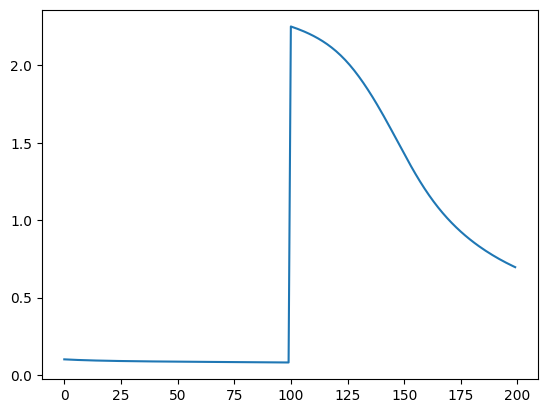

In [20]:
# Plot progress (loss function)
plt.plot(np.arange(len(losses)), losses)

## Compute metrics over ```X_test``` images

In [21]:
progress = tqdm(range( 0 , len(X_test) , batch_size ), ncols=100)
predictions = []

for i in progress : # Iterate over all batches of data
  #
  batch_X = X_test[i: i + batch_size]
  batch_y = y_test[i: i + batch_size]
  batch_X = torch.from_numpy(batch_X).type(torch.FloatTensor)#.to("cuda") #.cuda()

  # Perform forward pass to compute predictions
  batch_predictions = model(batch_X)
  predictions.extend(np.argmax(batch_predictions.detach().cpu().numpy(), axis=1))


100%|██████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 891.01it/s]


acc: 0.832


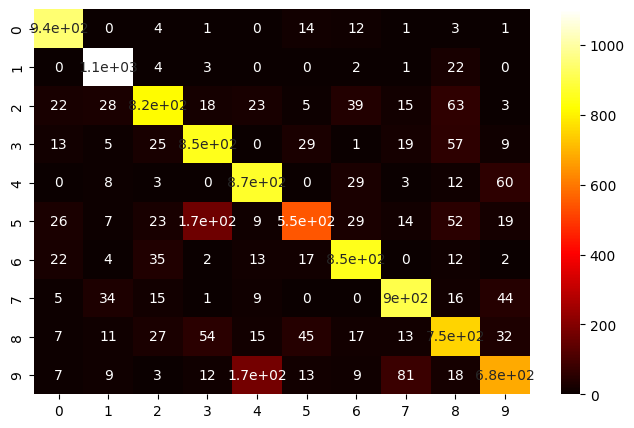

In [22]:
y_test_ = np.argmax(y_test, axis=1)
acc = accuracy_score(y_test_, predictions)
cm_ = confusion_matrix(y_test_, predictions)

# Compute confusion matrix and accuracy
_, ax = plt.subplots(figsize=(8,5))
sns.heatmap(cm_, cmap="hot", annot=True, ax=ax)
print("acc: {0}".format(acc))